In [1]:
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
item_to_id = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/9.grocery cluster/item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [4]:
purchase_history = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/9.grocery cluster/purchase_history.csv')
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [5]:
purchase_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [6]:
purchase_history['user_id'].nunique()

24885

### Build user-item count matrix

In [7]:
def item_counts_by_user(same_user_df):
    # 'sum' here is adding two lists into one big list
    all_item_ids = same_user_df['id'].str.split(',').sum()
    # transform from string to int, make it easier to be sorted later
    return pd.Series(Counter(int(id) for id in all_item_ids))

In [8]:
user_item_counts = purchase_history.groupby('user_id').apply(item_counts_by_user).unstack(fill_value=0)

In [9]:
user_item_counts.shape

(24885, 48)

In [10]:
# each row in user_item_counts represents one user
# each column in user_item_counts represents one item
# [u,i] holds the number which user 'u' boughts item 'i'
user_item_counts.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
37761,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
108680,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1
315158,1,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
668170,1,0,0,0,0,0,0,1,0,1,...,1,0,2,1,0,0,0,0,1,0
472174,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0


### Q1: The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder: 

##### the customer who bought the most items overall in her lifetime
Customer '269335' bought 72 items, which is the most.

In [11]:
user_count = user_item_counts.sum(axis=1).reset_index().rename(columns={0: 'count'})
user_count.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


##### for each item, the customer who bought that product the most

In [12]:
item_user = user_item_counts.idxmax().reset_index().rename(columns={'index':'Item_id', 0: 'User_id'})
item_user.head()

,Item_id,User_id
0,1,31625
1,2,31625
2,3,154960
3,4,5289
4,5,217277


In [13]:
item_user_cnt = user_item_counts.max().reset_index().rename(columns={'index':'Item_id', 0: 'max_count'})
item_user_cnt.head()

,Item_id,max_count
0,1,4
1,2,5
2,3,4
3,4,3
4,5,3


In [14]:
df = pd.merge(left=item_user, right=item_to_id, on='Item_id', how='left')
df = pd.merge(left=df, right=item_user_cnt, on='Item_id', how='left')
df = df[['Item_id', 'Item_name', 'User_id','max_count']].set_index('Item_id')
df

,Item_name,User_id,max_count
Item_id,,,
1,sugar,31625,4
2,lettuce,31625,5
3,pet items,154960,4
4,baby items,5289,3
5,waffles,217277,3
6,poultry,334664,4
7,sandwich bags,175865,3
8,butter,151926,3
9,soda,269335,4


### Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

### Build item-item similarity matrix

In [15]:
# A is |U|*|I|, and each item is normalized
A = normalize(user_item_counts.values, axis=0)
item_item_similarity = A.T.dot(A)
item_item_similarity = pd.DataFrame(item_item_similarity,
                                    index=user_item_counts.columns,
                                    columns=user_item_counts.columns)

In [16]:
item_item_similarity.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


<AxesSubplot:>

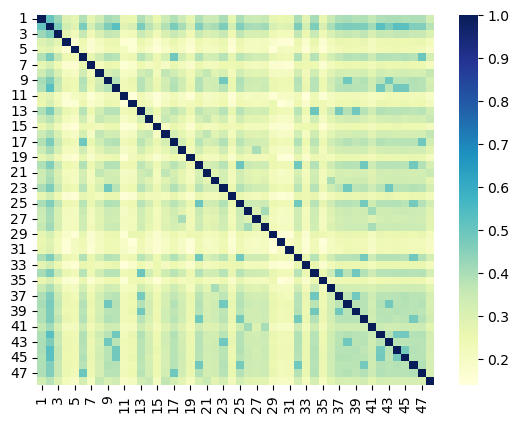

In [17]:
sns.heatmap(item_item_similarity, cmap='YlGnBu')

### Clustering

In [18]:
# define the feature matrix: item_id, user_id
feature = user_item_counts.T
feature.shape

(48, 24885)

In [19]:
feature

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,1,0,1,0,0,0,...,0,1,1,1,0,0,1,1,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
9,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
10,0,1,0,1,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,2,1


In [20]:
# determine the best number of clusters
clusters = range(2, 10)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=10)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

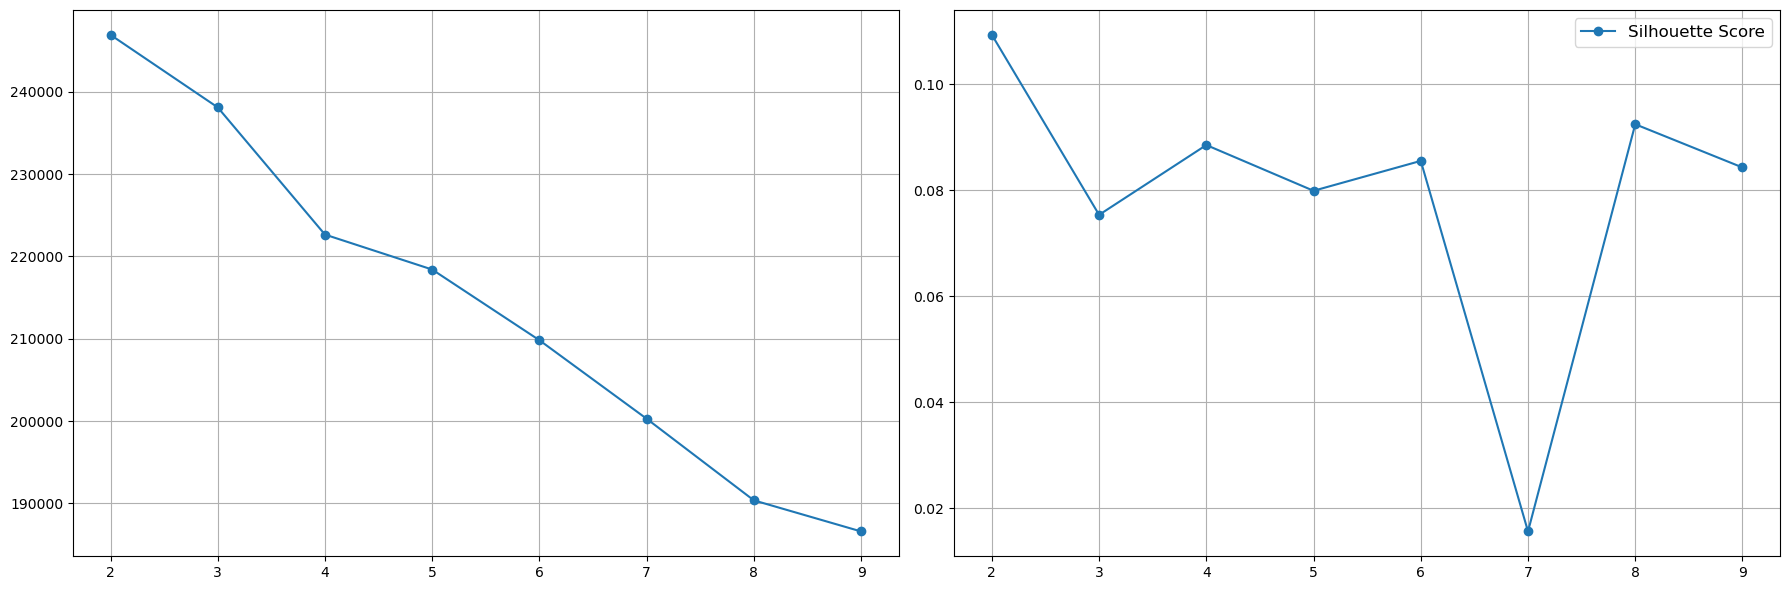

In [21]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Score')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

It seems 8 clusters is the best choice. Now, let's apply PCA on the data and visualize the data.

In [22]:
# build K-Means model
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=0)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [23]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=10)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

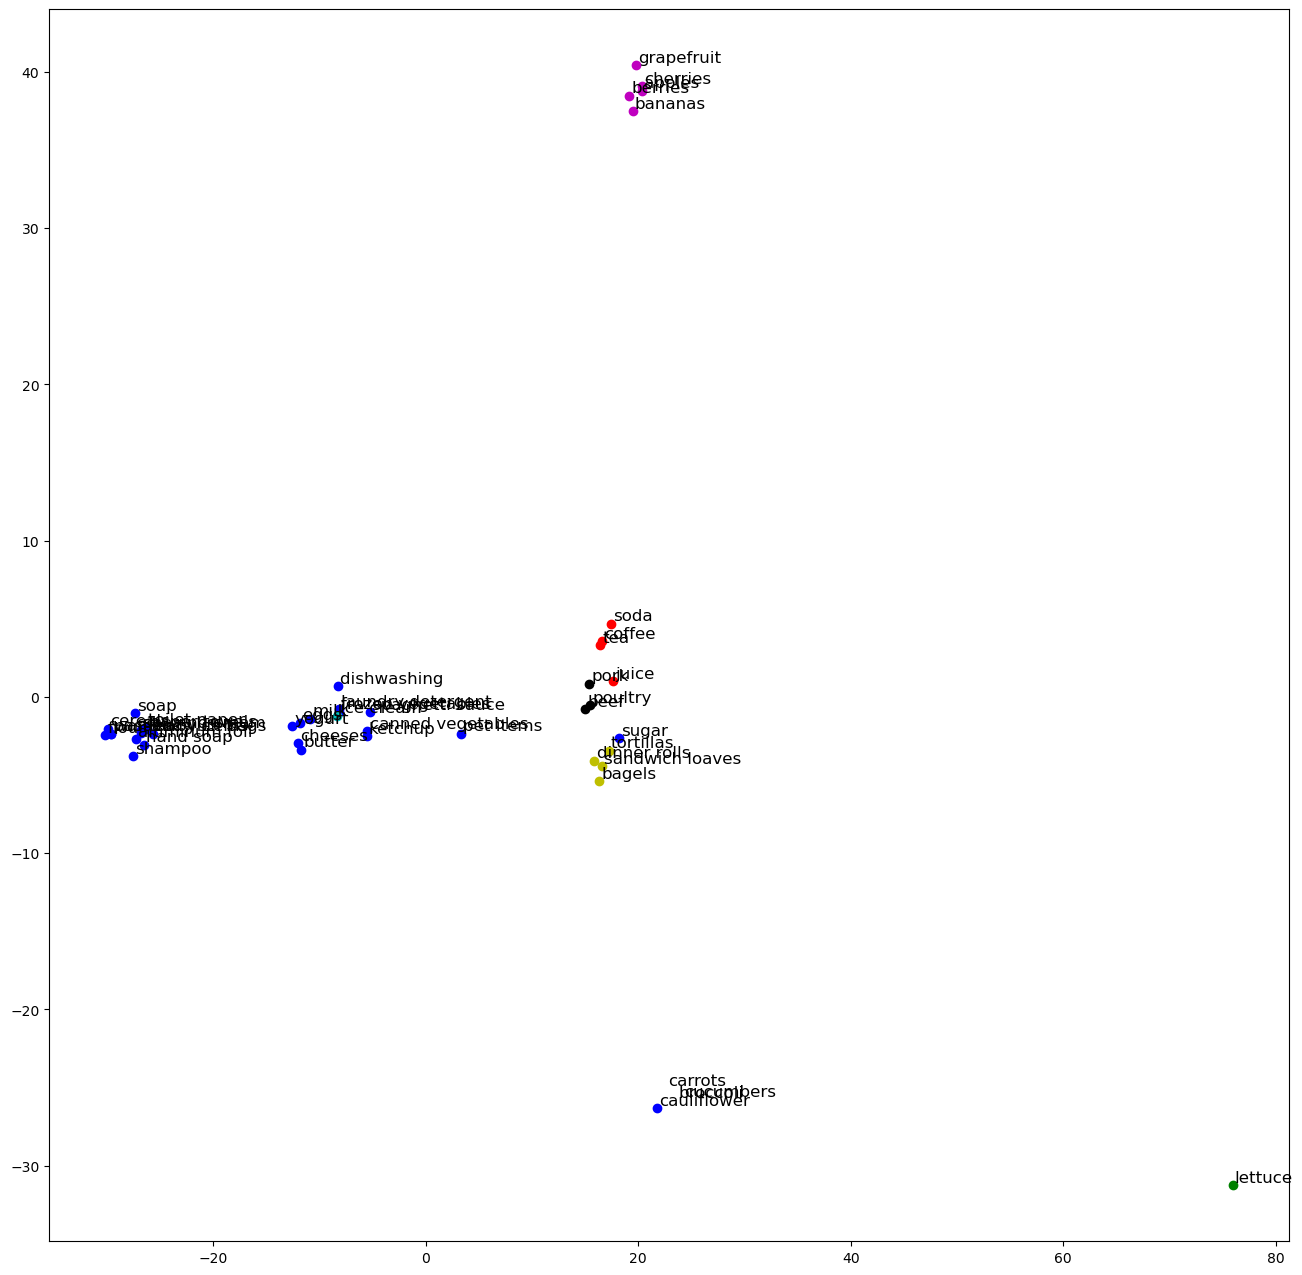

In [24]:
# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), text=name.values[0], fontsize=12)

plt.show()

In [25]:
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 8):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['sugar', 'pet items', 'baby items', 'waffles', 'sandwich bags', 'butter', 'cereals', 'shampoo', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'toilet paper', 'soap', 'ketchup', 'cauliflower', 'yogurt']
1 	 ['lettuce']
2 	 ['soda', 'tea', 'juice', 'coffee']
3 	 ['ice cream']
4 	 ['grapefruit', 'cherries', 'apples', 'berries', 'bananas']
5 	 ['bagels', 'tortillas', 'dinner rolls', 'sandwich loaves']
6 	 ['poultry', 'beef', 'pork']
7 	 ['carrots', 'cucumbers', 'broccoli']
